In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.dates import  DateFormatter
# %matplotlib inline
from astropy.io import fits
import datetime
from astropy import units as u
from astropy.coordinates import SkyCoord, EarthLocation, AltAz
import time

In [2]:
from some_func import cart2spheric, spheric2cart, spheric_coordinates_rotate, hor2pix_keo, bright_relay_keo

In [3]:
# Координаты расположения KEO
lat_keo=55.9305361 # ШИРОТА
lon_keo=48.7444861 # ДОЛГОТА
h_keo=91.0
KEO_site=EarthLocation(lat=lat_keo*u.deg, lon=lon_keo*u.deg, height=h_keo*u.m)

# Ориентация KEO - 24 августа
az0_keo = 6.0729592128071603;
alt0_keo = 1.5428754318596944;
a_keo = (   1.1260974991748651,   -0.0048692544335450,    0.0004054871474967)
b_keo = (   1.3414326667154699,   -0.0003973836009369,   -0.0048666234384367)
c_keo = ( 252.5023732028608379, -203.9735999213842206,  -16.9930115762693461)
d_keo = ( 255.0212588337721229,   16.6581624996323754, -204.0858265523006594)

In [4]:
dark_filename='../DATA/02_KEO/140824/dark/keo_aug24_dark_median.fit'
dark=fits.getdata(dark_filename);
dark.astype('d')
BS6300_catalog_filename='Haritonov_6300BS_catalog.npz'

In [5]:
npzfile=np.load(BS6300_catalog_filename)
CAT_FIELDS=npzfile['CAT_FIELDS']
CAT_6300BS=npzfile['CAT_6300BS']
CAT_SPTYPE=npzfile['CAT_SPTYPE']
print(CAT_FIELDS)

['HARITONOV_ID' 'BS_ID' 'RA (icrs, deg)' 'DEC (icrs, deg)' 'MAG_V'
 '6300 Flux (erg/(sm^2 * s *  sm))']


In [6]:
# img_num_start=2507
img_num_start=2106
# img_num_end=2106
img_num_end=2507
img_num_list=[]
R_median_list=[]
R_median_sum=0.
time_axe=[]
ind=0
for img_num in range(img_num_start,img_num_end+1):
#     pic_save_name='/home/ashindin/temp/' + "{0:0>3}".format(img_num) + '.png'
    ind+=1
    pic_save_name='./.temp/keo_aug24/' + "{0:0>4}".format(ind) + '.jpg'
    fig=plt.figure(figsize=(9.5,4.5))
    ax = plt.subplot(121)
    ax.grid(True)
    ax.set_xlim((100, 1300))
    ax.set_ylim((0, 0.5))
    plt.ylabel('Calibration coef. [R/ADCu]')
    plt.xlabel('Star brightness per pixel [R]')
    ax2=plt.subplot(122)
    ax2.set_xlim((511,1))
    ax2.set_ylim((511,1))
        
    fit_filename='../DATA/02_KEO/140824/20140824_' + "{0:0>3}".format(img_num) + '.fit'
    
    fid_fit=fits.open(fit_filename);
    date_obs_str=fid_fit[0].header["DATE-OBS"]
    img=fid_fit[0].data;
    img=img.astype('d')
    fid_fit.close()
    
    img=img-dark
    plt.axes(ax2)
    plt.pcolormesh(img, cmap="gray", vmin=np.median(img)-300, vmax=np.median(img)+300)
    date_obs=datetime.datetime.strptime(date_obs_str,"%Y-%m-%dT%H:%M:%S")+datetime.timedelta(seconds=15)
    
    plt.title('fr'+"{0:0>4}".format(img_num) + ' ' + str(date_obs)[0:23])
    time_axe.append(date_obs)
    
    print("{0:0>3}".format(img_num) + " "+ str(date_obs))

    BS_coord=SkyCoord(CAT_6300BS[:,2], CAT_6300BS[:,3], frame='icrs', unit='deg');
    
    altaz=BS_coord.transform_to(AltAz(obstime=date_obs, location=KEO_site,temperature=15*u.deg_C,pressure=1013*u.hPa,
                                       relative_humidity=0.5,obswl=630.0*u.nm))
    BS_AzAlt=np.zeros((np.size(CAT_6300BS,0),2))
    BS_AzAlt[:,0]=altaz.az.degree
    BS_AzAlt[:,1]=altaz.alt.degree
#     print(BS_AzAlt[28,0],BS_AzAlt[28,1])

    BS_xy=np.zeros((np.size(CAT_6300BS,0),2))
    BS_xy[:,0], BS_xy[:,1] = hor2pix_keo (BS_AzAlt[:,0]*np.pi/180,BS_AzAlt[:,1]*np.pi/180, az0_keo, alt0_keo, c_keo, d_keo)

    # Catalog filtration
    filt_mask=np.zeros(np.size(CAT_6300BS,0),dtype=bool)
    for i in range(0,np.size(CAT_6300BS,0)):
        if BS_AzAlt[i,1]>=44.0 and BS_AzAlt[i,1]<=62.0:
            if BS_xy[i,0]>=1 and BS_xy[i,0]<=511:
                if BS_xy[i,1]>=1 and BS_xy[i,1]<=511:
                    filt_mask[i]=True
    BS_AzAlt_filt=BS_AzAlt[filt_mask,:]
    BS_xy_filt=BS_xy[filt_mask,:]
    CAT_6300BS_filt=CAT_6300BS[filt_mask,:]
    CAT_SPTYPE_filt=CAT_SPTYPE[filt_mask]
    if len(CAT_6300BS_filt)!=0:
        img_red_st_int=np.zeros(np.size(BS_xy_filt,0))
        img_red_st_num=np.zeros(np.size(BS_xy_filt,0))
        BS_adc_filt=np.zeros(np.size(BS_xy_filt,0))
        area_rad=2
        for j in range(np.size(BS_xy_filt,0)):    
            st_x=BS_xy_filt[j,0]
            st_y=BS_xy_filt[j,1]
            area=img[int(st_y)-area_rad:int(st_y)+area_rad+1, int(st_x)-area_rad:int(st_x)+area_rad+1]

            sum_temp=0.0
            num=0
            med=np.median(area)
            for i in range(len(area.flat)):
                if area.flat[i]>=1.3*med:
                    num+=1
                    sum_temp+=area.flat[i]-med
            img_red_st_int[j]=sum_temp
            img_red_st_num[j]=num
            if num>0:
                BS_adc_filt[j]=sum_temp/num

        BS_relay=np.zeros(np.size(BS_xy_filt,0))
        R_adc_coef=np.zeros(np.size(BS_xy_filt,0))
        for i in range(np.size(BS_xy_filt,0)):
             if img_red_st_num[i]>3:
                    BS_relay[i]=bright_relay_keo(CAT_6300BS_filt[i,5],img_red_st_num[i])
                    if BS_adc_filt[i]>0 and BS_relay[i]>100:
                        R_adc_coef[i]=BS_relay[i]/BS_adc_filt[i]

    #     print(R_adc_coef[R_adc_coef.nonzero()])
        R_median=np.median(R_adc_coef[R_adc_coef.nonzero()])
        R_median_sum+=R_median

        print(R_median)
        R_median_list.append(R_median)
        img_num_list.append(img_num)
        
        plt.axes(ax)
        plt.plot([0, 5000], [R_median, R_median], c='r', lw=2)
        plt.scatter(BS_relay,R_adc_coef,s=np.pi*(img_red_st_num)**2)
        plt.ylabel('Calibration coef. [R/ADCu]')
        plt.xlabel('Star brightness per pixel [R]')

        plt.title(R_median)

        plt.axes(ax2)
        plt.plot(BS_xy_filt[:,0],BS_xy_filt[:,1],color="r",marker=".", lw=0.,mec="r", mfc="r")
        
#         for ii in range(len(CAT_6300BS_filt)):
#             ax2.text(BS_xy_filt[ii,0]-10, BS_xy_filt[ii,1]-10, str(int(CAT_6300BS_filt[ii,0])), ha="center", va="center", size=12)
        
        
        # plt.show()
    plt.savefig(pic_save_name)
    plt.close()
print(' ')
print(R_median_sum/(img_num_end-img_num_start+1))

2106 2014-08-24 17:16:20


/usr/local/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/usr/local/lib/python3.5/site-packages/numpy/core/_methods.py:70: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


nan
2107 2014-08-24 17:16:51
nan
2108 2014-08-24 17:17:22
nan
2109 2014-08-24 17:17:53
0.241746599395
2110 2014-08-24 17:18:24
nan
2111 2014-08-24 17:18:55
nan
2112 2014-08-24 17:19:26
nan
2113 2014-08-24 17:19:57
nan
2114 2014-08-24 17:20:28
nan
2115 2014-08-24 17:20:59
nan
2116 2014-08-24 17:21:30
nan
2117 2014-08-24 17:22:01
nan
2118 2014-08-24 17:22:32
0.229386323362
2119 2014-08-24 17:23:03
0.422648246668
2120 2014-08-24 17:23:34
0.396621044333
2121 2014-08-24 17:24:05
0.390579016151
2122 2014-08-24 17:24:35
nan
2123 2014-08-24 17:25:06
0.408863843539
2124 2014-08-24 17:25:37
0.550140903762
2125 2014-08-24 17:26:08
0.401407410879
2126 2014-08-24 17:26:39
0.474697852244
2127 2014-08-24 17:27:10
0.667559926558
2128 2014-08-24 17:27:41
0.359540957194
2129 2014-08-24 17:28:12
0.383893191638
2130 2014-08-24 17:28:43
0.419717174471
2131 2014-08-24 17:29:14
0.352739182308
2132 2014-08-24 17:29:45
0.452807686878
2133 2014-08-24 17:30:16
0.384774085907
2134 2014-08-24 17:30:47
0.3709671372

In [7]:
dates = matplotlib.dates.date2num(time_axe)

<IPython.core.display.Javascript object>


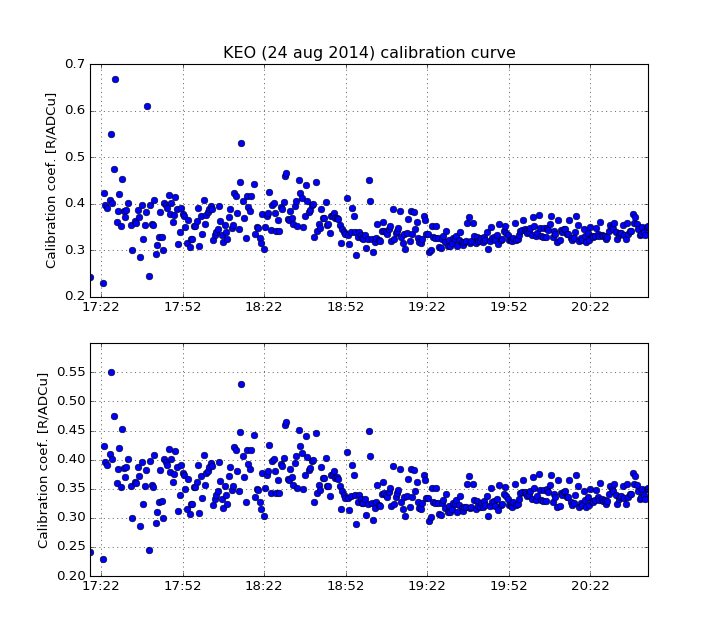

In [10]:
% matplotlib notebook
fig=plt.figure(figsize=(9,8))
ax = plt.subplot(211)
# plt.scatter(img_num_list,R_median_list)
plt.plot_date(dates,R_median_list)
#ax.set_ylim((0,5))
ax.grid(True)
# plt.gcf().autofmt_xdate()
ax.xaxis.set_major_formatter( DateFormatter('%H:%M') )
plt.ylabel('Calibration coef. [R/ADCu]')

plt.title('KEO (24 aug 2014) calibration curve')

ax2=plt.subplot(212)
plt.plot_date(dates,R_median_list)
ax2.set_ylim((0.2,0.6))
ax2.grid(True)
# plt.gcf().autofmt_xdate()
ax2.xaxis.set_major_formatter( DateFormatter('%H:%M') )
plt.ylabel('Calibration coef. [R/ADCu]')

plt.show()
# plt.savefig('./.temp/keo_aug24.png')

In [9]:
# img_num=2408
# img_num=2507
R_median_sum=0.
for img_num in range(2392,2508):

    pic_save_name='./.temp/' + str(img_num) + '.png'

    fit_filename='../DATA/02_KEO/140824/20140824_' + str(img_num) + '.fit'

    fid_fit=fits.open(fit_filename);
    date_obs_str=fid_fit[0].header["DATE-OBS"]
    img=fid_fit[0].data;
    img=img.astype('d')
    fid_fit.close()
    
    img=img-dark
    date_obs=datetime.datetime.strptime(date_obs_str,"%Y-%m-%dT%H:%M:%S")+datetime.timedelta(seconds=15)
    print(date_obs)

    BS_coord=SkyCoord(CAT_6300BS[:,2], CAT_6300BS[:,3], frame='icrs', unit='deg');

    altaz=BS_coord.transform_to(AltAz(obstime=date_obs, location=KEO_site,temperature=15*u.deg_C,pressure=1013*u.hPa,
                                           relative_humidity=0.5,obswl=630.0*u.nm))
    BS_AzAlt=np.zeros((np.size(CAT_6300BS,0),2))
    BS_AzAlt[:,0]=altaz.az.degree
    BS_AzAlt[:,1]=altaz.alt.degree

#     print(BS_AzAlt[28,0],BS_AzAlt[28,1])

    BS_xy=np.zeros((np.size(CAT_6300BS,0),2))
    BS_xy[:,0], BS_xy[:,1] = hor2pix_keo (BS_AzAlt[:,0]*np.pi/180,BS_AzAlt[:,1]*np.pi/180, az0_keo, alt0_keo, c_keo, d_keo)

    # Catalog filtration
    filt_mask=np.zeros(np.size(CAT_6300BS,0),dtype=bool)
    for i in range(0,np.size(CAT_6300BS,0)):
        if BS_AzAlt[i,1]>=44.0 and BS_AzAlt[i,1]<=62.0:
            if BS_xy[i,0]>=1 and BS_xy[i,0]<=511:
                if BS_xy[i,1]>=1 and BS_xy[i,1]<=511:
                    filt_mask[i]=True
    BS_AzAlt_filt=BS_AzAlt[filt_mask,:]
    BS_xy_filt=BS_xy[filt_mask,:]
    CAT_6300BS_filt=CAT_6300BS[filt_mask,:]
    CAT_SPTYPE_filt=CAT_SPTYPE[filt_mask]

    img_red_st_int=np.zeros(np.size(BS_xy_filt,0))
    img_red_st_num=np.zeros(np.size(BS_xy_filt,0))
    BS_adc_filt=np.zeros(np.size(BS_xy_filt,0))
    area_rad=2
    for j in range(np.size(BS_xy_filt,0)):    
        st_x=BS_xy_filt[j,0]
        st_y=BS_xy_filt[j,1]
        area=img[int(st_y)-area_rad:int(st_y)+area_rad+1, int(st_x)-area_rad:int(st_x)+area_rad+1]

        sum_temp=0.0
        num=0
        med=np.median(area)
        for i in range(len(area.flat)):
            if area.flat[i]>=1.3*med:
                num+=1
                sum_temp+=area.flat[i]-med
        img_red_st_int[j]=sum_temp
        img_red_st_num[j]=num
        if num>0:
            BS_adc_filt[j]=sum_temp/num

    BS_relay=np.zeros(np.size(BS_xy_filt,0))
    R_adc_coef=np.zeros(np.size(BS_xy_filt,0))
    for i in range(np.size(BS_xy_filt,0)):
         if img_red_st_num[i]>3:
                BS_relay[i]=bright_relay_keo(CAT_6300BS_filt[i,5],img_red_st_num[i])
                if BS_adc_filt[i]>0 and BS_relay[i]>100:
                    R_adc_coef[i]=BS_relay[i]/BS_adc_filt[i]

#     print(R_adc_coef[R_adc_coef.nonzero()])
    R_median=np.median(R_adc_coef[R_adc_coef.nonzero()])
    R_median_sum+=R_median
    
    print(R_median)

    fig,ax = plt.subplots()
    plt.plot([0, 5000], [R_median, R_median], c='r', lw=2)
    plt.scatter(BS_relay,R_adc_coef,s=np.pi*(img_red_st_num)**2)
    plt.ylabel('Calibration coef. [R/ADCu]')
    plt.xlabel('Star brightness per pixel [R]')
    plt.title(date_obs, loc='left')
    plt.title(R_median, loc='right')
    ax.set_xlim((100, 1300))
    ax.set_ylim((0, 0.5))
    # plt.show()
    plt.savefig(pic_save_name)
    plt.close()
print(' ')
print(R_median_sum/116)

2014-08-24 19:43:55
0.338240288528
2014-08-24 19:44:25
0.303189396582
2014-08-24 19:44:56
0.320760244795
2014-08-24 19:45:27
0.350800601045
2014-08-24 19:45:58
0.326335536969
2014-08-24 19:46:29
0.328847348534
2014-08-24 19:47:00
0.320831787727
2014-08-24 19:47:31
0.332980470454
2014-08-24 19:48:02
0.313044464292
2014-08-24 19:48:33
0.356067664345
2014-08-24 19:49:04
0.32284256483
2014-08-24 19:49:35
0.323740614425
2014-08-24 19:50:06
0.340293483946
2014-08-24 19:50:37
0.352694798061
2014-08-24 19:51:08
0.337818456141
2014-08-24 19:51:39
0.331665765366
2014-08-24 19:52:10
0.321887399165
2014-08-24 19:52:41
0.321795436591
2014-08-24 19:53:12
0.319368375626
2014-08-24 19:53:43
0.32643244433
2014-08-24 19:54:14
0.357515747933
2014-08-24 19:54:45
0.3227559375
2014-08-24 19:55:16
0.322979655144
2014-08-24 19:55:47
0.332003511543
2014-08-24 19:56:17
0.341985022769
2014-08-24 19:56:48
0.343679504633
2014-08-24 19:57:19
0.364264433782
2014-08-24 19:57:50
0.344620820707
2014-08-24 19:58:21
0.34